In [1]:
import numpy as np
np.random.seed(43)

import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

import pickle

from prepdata.preparing_data import *
import discriminant_methods as dm
from models import *

from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
dae = DiscriminativeAutoEncoder(input_shape=100, layers=[100, 64, 32, 16], classes_num=2, )

Input dimension - 16
Input dimension - 100
Creating layer with 100
Creating layer with 64
Creating layer with 32
Creating layer previous with 16
Creating layer with 32
Creating layer with 64
Creating layer with 100
Input dimension - 100
[Errno 17] File exists: './spits'
[Errno 17] File exists: './spits'
[Errno 17] File exists: './spits/pickle/'
[Errno 17] File exists: './spits/saved_models/'


## Getting data

In [2]:
cv = StratifiedKFold(n_splits=10, random_state=512, shuffle=True)

In [3]:
DATA17_PATH = f'/home/marina.juca/data/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97_et4_eta0.npz'
DATAMC16_PATH = '/home/marina.juca/data/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2_et4_eta0.npz'

d17 = loadfile(DATA17_PATH)
mc16 = loadfile(DATAMC16_PATH)

data17 = norm1(d17['data'][:, 1:101])
data16 = norm1(mc16['data_float'][:, 12:112])


d17target = d17['target']
mc16target = mc16['target']

normdf17 = pd.DataFrame(data17)
normdf17['targets'] = d17target

criterea = normdf17['targets'] == 0 # creates a boolean array with all jets data from data17
#normdf17 = normdf17[~criterea] # removes all jets data from data17
data17 = data17[~criterea] # removes all jets data from data17
d17target = d17target[~criterea] # removes all jets data from data17

d17target[d17target == 1] = 0
#mc16target[mc16target != 1] = 0  

df17 = pd.DataFrame(data17)
df16 = pd.DataFrame(data16)
df17['targets'] = d17target
df16['targets'] = mc16target


d17splits = [(train_index, val_index) for train_index, val_index in cv.split(data17,d17target)]
mc16splits = [(train_index, val_index) for train_index, val_index in cv.split(data16,mc16target)]

folds17_list = np.zeros(df17.shape[0])
folds16_list = np.zeros(df16.shape[0])

for fold in range(10):
    for idx in d17splits[fold][0]:
        folds17_list[idx] = True
        
    for idx in d17splits[fold][1]:
        folds17_list[idx] = False
    
    folds17_list = folds17_list.astype(bool)
    df17[f'is_train_fold_{fold}'] = folds17_list

    for idx in mc16splits[fold][0]:
        folds16_list[idx] = True
        
    for idx in mc16splits[fold][1]:
        folds16_list[idx] = False
        
    folds16_list = folds16_list.astype(bool)
    df16[f'is_train_fold_{fold}'] = folds16_list
    
df = pd.concat([df17,df16])

In [4]:
df = pd.concat([df17,df16])

train_x = df[df['is_train_fold_0'] == True].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()

train_y = df[df['is_train_fold_0'] == True]['targets'].to_numpy().astype(int)
test_x = df[df['is_train_fold_0'] == False].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()
test_y = df[df['is_train_fold_0'] == False]['targets'].to_numpy().astype(int)

## Fold 0

In [56]:
np.unique(predicted_class)

array([0, 1])

In [59]:
test_y.shape

(173875,)

In [61]:
predicted_class.shape

(1564865,)

In [62]:
from sklearn.metrics import accuracy_score

accuracies = []
for ifold in range(10):
    print('fold:',ifold)
    
    loadmodels = DiscriminativeAutoEncoder(input_shape=100, layers=[100, 64, 32, 16], classes_num=2, file_path=f'./spits/trainings/et4eta0/fold{fold}')
    loadmodels.load(model_name='all_model')
    print('loaded model')
    
    train_x = df[df[f'is_train_fold_{ifold}'] == True].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()
    train_y = df[df[f'is_train_fold_{ifold}'] == True]['targets'].to_numpy().astype(int)
    test_x = df[df[f'is_train_fold_{ifold}'] == False].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()
    test_y = df[df[f'is_train_fold_{ifold}'] == False]['targets'].to_numpy().astype(int)
    print('train and test divided')
    
    print('start prediction')
    model_output = loadmodels.predict(test_x)
    predicted_class = np.argmax(model_output, axis=1)
    

    accuracy = accuracy_score(test_y, predicted_class)
    print('accuracy:', accuracy)
    accuracies.append(accuracy)
    
# Calculate mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print('mean:',mean_accuracy)
print('desvio padrao:',std_accuracy)

fold: 0
Input dimension - 16
Input dimension - 100
Creating layer with 100
Creating layer with 64
Creating layer with 32
Creating layer previous with 16
Creating layer with 32
Creating layer with 64
Creating layer with 100
Input dimension - 100
[Errno 17] File exists: './spits'
[Errno 17] File exists: './spits/trainings'
[Errno 17] File exists: './spits/trainings/et4eta0'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0/pickle/'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0/saved_models/'
DiscriminateAutoEncoder.load Function
loaded model
train and test divided
start prediction
DiscriminateAutoEncoder.predict Function
accuracy: 0.9927706685837527
fold: 1
Input dimension - 16
Input dimension - 100
Creating layer with 100
Creating layer with 64
Creating layer with 32
Creating layer previous with 16
Creating layer with 32
Creating layer with 64
Creating la

In [4]:
test_x_7 = df[df['is_train_fold_7'] == False].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()
test_y_7 = df[df['is_train_fold_7'] == False]['targets'].to_numpy().astype(int)

In [7]:
len(d17splits)

10

In [28]:
len(d17splits[0][1])

169955

## Analysing data

In [29]:
test_y.shape

(173875,)

In [71]:
unique, frequency = np.unique(test_y,
                              return_counts = True)
count = np.asarray((unique, frequency ))
 
print("The values and their frequency are:\n",
     count)

The values and their frequency are:
 [[     0      1]
 [169955   3920]]


In [72]:
unique, frequency = np.unique(train_y,
                              return_counts = True)
count = np.asarray((unique, frequency ))
 
print("The values and their frequency are:\n",
     count)

The values and their frequency are:
 [[      0       1]
 [1529586   35279]]


In [5]:
unique, frequency = np.unique(test_y_7,
                              return_counts = True)
count = np.asarray((unique, frequency ))
 
print("The values and their frequency are:\n",
     count)

The values and their frequency are:
 [[     0      1]
 [169954   3920]]


In [5]:
np.unique(test_y)

array([-1,  1])

In [50]:
test_y.shape

(173875,)

In [51]:
train_y.shape

(1564865,)

In [46]:
pd.DataFrame(train_x)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.019066,0.005989,-0.003278,0.004796,-0.004123,0.002261,0.000599,0.000884,0.083612,0.139679,...,0.004335,-0.005198,-0.000768,-0.000455,0.002039,-0.002476,0.000000,0.000010,0.000930,-0.001285
1,0.009510,0.001906,0.006928,-0.000264,0.002612,0.003397,0.000163,-0.000834,0.103557,0.078046,...,-0.000008,0.004702,0.000050,0.000182,0.000639,0.006177,0.000015,0.000057,0.001511,0.000236
2,0.043170,0.002320,-0.001741,-0.004943,0.003224,-0.001561,0.002055,-0.000291,0.150500,0.104810,...,0.024336,0.005791,-0.000414,0.000485,0.010397,-0.002917,0.000147,0.000779,0.000762,0.000623
3,0.028080,0.005256,-0.003272,-0.002153,0.006529,0.002643,0.003077,-0.001492,0.105023,0.120504,...,0.004762,0.002841,0.000593,-0.000025,0.001228,0.002172,0.001044,0.001160,0.000497,0.000389
4,0.014573,0.011650,0.000505,-0.002489,-0.000776,-0.003047,0.004182,-0.001513,0.098124,0.084477,...,0.009123,0.021570,-0.000325,-0.000819,0.000059,0.007818,-0.000030,0.000160,-0.000309,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564860,0.004800,0.001064,0.000282,0.000263,0.000172,0.000101,-0.000020,-0.000429,0.069673,0.034306,...,-0.001052,-0.000122,-0.000022,-0.000172,-0.000087,0.000076,0.000002,-0.000008,0.000057,0.000411
1564861,0.002705,0.000156,0.000533,0.000384,-0.000002,0.000165,0.002957,0.000376,0.034649,0.028022,...,0.000476,0.001358,-0.000008,0.000021,0.000830,0.000025,0.000000,0.000039,-0.000006,-0.000022
1564862,0.002705,0.000156,0.000533,0.000384,-0.000002,0.000165,0.002957,0.000376,0.034649,0.028022,...,0.000476,0.001358,-0.000008,0.000021,0.000830,0.000025,0.000000,0.000039,-0.000006,-0.000022
1564863,0.001775,0.000172,-0.000044,-0.000037,-0.000021,-0.000193,0.000056,0.001448,0.047028,0.023031,...,-0.000093,0.000434,0.000083,0.000032,-0.000131,0.000212,0.000000,-0.000006,0.000004,0.000026


In [6]:
from keras.utils.np_utils import to_categorical
train_targets = to_categorical(train_y)
test_targets = to_categorical(test_y)

In [5]:
test_targets

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [6]:
train_y

array([0, 0, 0, ..., 1, 1, 1])

# Analysing model

#### Outside class

In [9]:
dir_path = './spits/trainings/et4eta0/saved_models'

for file in os.listdir(dir_path):
    if file.split('.')[1] == "keras":
        print("ANALISED MODEL:", file)
        model = tf.keras.models.load_model(dir_path + '/' + file)
        model.summary()
        print('####################################################################')

ANALISED MODEL: all_model_ecd.keras
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
fc0 (Dense)                  (None, 100)               10100     
_________________________________________________________________
fc1 (Dense)                  (None, 64)                6464      
_________________________________________________________________
fc2 (Dense)                  (None, 32)                2080      
_________________________________________________________________
fc4 (Dense)                  (None, 16)                528       
Total params: 19,172
Trainable params: 19,172
Non-trainable params: 0
______________

## Fold 0

### Loading model

In [20]:
loadmodels = DiscriminativeAutoEncoder(input_shape=100, layers=[100, 64, 32, 16], classes_num=2, file_path='./spits/trainings/et4eta0/fold0')

Input dimension - 16
Input dimension - 100
Creating layer with 100
Creating layer with 64
Creating layer with 32
Creating layer previous with 16
Creating layer with 32
Creating layer with 64
Creating layer with 100
Input dimension - 100
[Errno 17] File exists: './spits'
[Errno 17] File exists: './spits/trainings'
[Errno 17] File exists: './spits/trainings/et4eta0'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0/pickle/'
[Errno 17] File exists: './spits/trainings/et4eta0/fold0/saved_models/'


In [5]:
loadmodels = DiscriminativeAutoEncoder(input_shape=100, layers=[100, 64, 32, 16], classes_num=2, file_path='./spits/trainings/et4eta0')

Input dimension - 16
Input dimension - 100
Creating layer with 100
Creating layer with 64
Creating layer with 32
Creating layer previous with 16
Creating layer with 32
Creating layer with 64
Creating layer with 100
Input dimension - 100
[Errno 17] File exists: './spits'
[Errno 17] File exists: './spits/trainings'
[Errno 17] File exists: './spits/trainings/et4eta0'
[Errno 17] File exists: './spits/trainings/et4eta0'
[Errno 17] File exists: './spits/trainings/et4eta0/pickle/'
[Errno 17] File exists: './spits/trainings/et4eta0/saved_models/'


In [8]:
loadmodels.is_trained

False

In [21]:
loadmodels.load(model_name='all_model')

DiscriminateAutoEncoder.load Function


0

In [36]:
model_output = loadmodels.predict(train_x)
predicted_class = np.argmax(model_output, axis=1)

DiscriminateAutoEncoder.predict Function


In [22]:
np.max(model_output[:,0])

1.0

In [23]:
from sklearn.metrics import classification_report
print(classification_report(train_y, predicted_class))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1529586
           1       0.91      0.76      0.82     35279

    accuracy                           0.99   1564865
   macro avg       0.95      0.88      0.91   1564865
weighted avg       0.99      0.99      0.99   1564865



In [37]:
model_output = loadmodels.predict(test_x)
predicted_class = np.argmax(model_output, axis=1)

DiscriminateAutoEncoder.predict Function


In [25]:
from sklearn.metrics import classification_report
print(classification_report(test_y, predicted_class))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    169955
           1       0.90      0.76      0.83      3920

    accuracy                           0.99    173875
   macro avg       0.95      0.88      0.91    173875
weighted avg       0.99      0.99      0.99    173875



classifier 0 loss : [1.6318886991939507e-05, 9.240909093932714e-06, 8.724167855689302e-06, 8.099489605228882e-06, 7.836859367671423e-06, 7.613647085236153e-06, 7.452993486367632e-06, 7.323381396417972e-06, 7.21682727089501e-06, 7.153629667300265e-06, 7.105094027792802e-06, 7.039579486445291e-06, 7.008368356764549e-06, 6.970574759179726e-06, 6.971663879085099e-06, 6.907286660862155e-06, 6.8733929765585344e-06, 6.849253168184077e-06, 6.8421672949625645e-06, 6.797943569836207e-06, 6.787415259168483e-06, 6.782965556340059e-06, 6.758420568075962e-06, 6.7071241574012674e-06, 6.702664904878475e-06, 6.675571057712659e-06, 6.664465672656661e-06, 6.649147962889401e-06, 6.63516311760759e-06, 6.576525720447535e-06, 6.590018529095687e-06, 6.581464731425513e-06, 6.535729880852159e-06, 6.556929747603135e-06, 6.535935881402111e-06, 6.505116743937833e-06, 6.5151411945407744e-06, 6.518485861306544e-06, 6.50806487101363e-06]
classifier 1 loss : [2.5430749701627064e-06, 2.532784719733172e-06, 2.5081703824

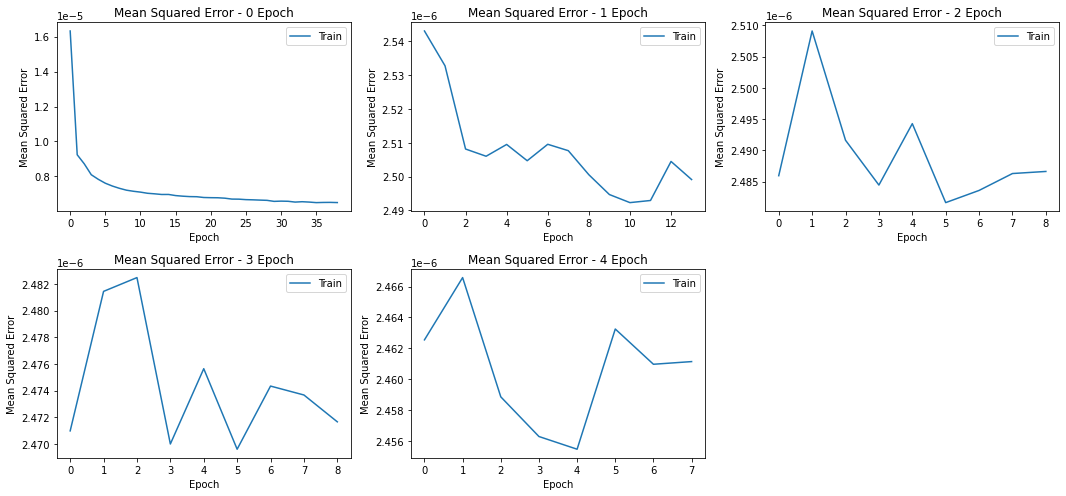

In [52]:
picklespath = './spits/trainings/et4eta0/fold0/pickle/'

# Define the number of columns and rows for the grid
num_columns = 3  # You can adjust this based on your preference
num_rows = 2     # You may need to adjust this based on the number of columns

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

for idx in range(len(os.listdir(picklespath))):
    row = idx // num_columns
    col = idx % num_columns
    with open(f'%s/modelhists_{idx}.pickle'%(picklespath), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        [rec_hist, clf_hist] = u.load()
        
        loss = rec_hist['loss']
        print(f'classifier {idx} loss : {loss}')
        axs[row,col].plot(rec_hist['loss'], label='Train')
        #plt.plot(rec_hist['val_loss'], label='Test')
        axs[row,col].set_title(f'Mean Squared Error - {idx} Epoch')
        axs[row,col].set_xlabel('Epoch')
        axs[row,col].set_ylabel('Mean Squared Error')
        axs[row, col].legend(loc='upper right')
        plt.savefig(f'leblonrctmse{idx}.png')

fig.delaxes(axs[1][2])

plt.tight_layout()
plt.savefig(f'./spits/plots/leblonrctmse{idx}.pdf')
plt.show()        

classifier 0 loss : [1.6318886991939507e-05, 9.240909093932714e-06, 8.724167855689302e-06, 8.099489605228882e-06, 7.836859367671423e-06, 7.613647085236153e-06, 7.452993486367632e-06, 7.323381396417972e-06, 7.21682727089501e-06, 7.153629667300265e-06, 7.105094027792802e-06, 7.039579486445291e-06, 7.008368356764549e-06, 6.970574759179726e-06, 6.971663879085099e-06, 6.907286660862155e-06, 6.8733929765585344e-06, 6.849253168184077e-06, 6.8421672949625645e-06, 6.797943569836207e-06, 6.787415259168483e-06, 6.782965556340059e-06, 6.758420568075962e-06, 6.7071241574012674e-06, 6.702664904878475e-06, 6.675571057712659e-06, 6.664465672656661e-06, 6.649147962889401e-06, 6.63516311760759e-06, 6.576525720447535e-06, 6.590018529095687e-06, 6.581464731425513e-06, 6.535729880852159e-06, 6.556929747603135e-06, 6.535935881402111e-06, 6.505116743937833e-06, 6.5151411945407744e-06, 6.518485861306544e-06, 6.50806487101363e-06]
classifier 1 loss : [2.5430749701627064e-06, 2.532784719733172e-06, 2.5081703824

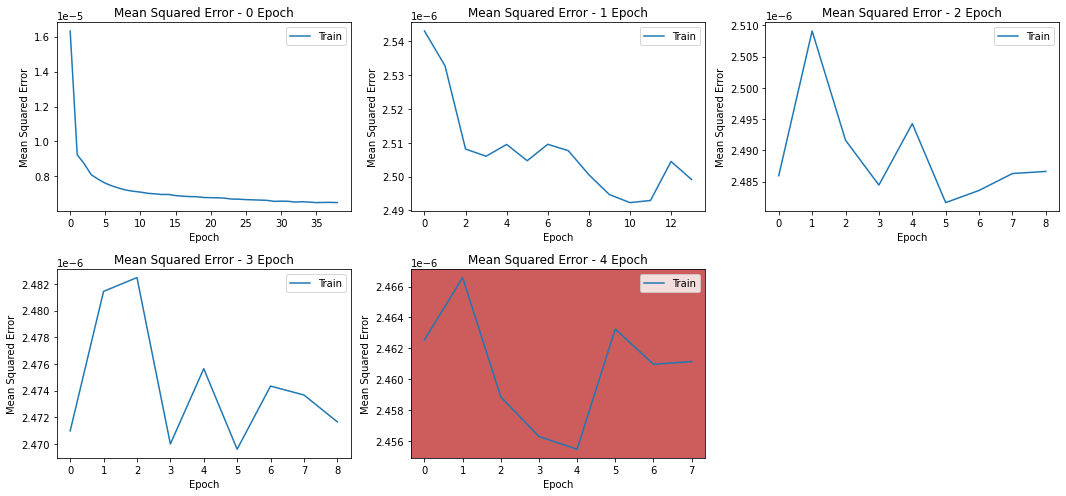

In [54]:
picklespath = './spits/trainings/et4eta0/fold0/pickle/'

# Define the number of columns and rows for the grid
num_columns = 3  # You can adjust this based on your preference
num_rows = 2     # You may need to adjust this based on the number of columns

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

for idx in range(len(os.listdir(picklespath))):
    row = idx // num_columns
    col = idx % num_columns
    with open(f'%s/modelhists_{idx}.pickle'%(picklespath), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        [rec_hist, clf_hist] = u.load()
        
        loss = rec_hist['loss']
        print(f'classifier {idx} loss : {loss}')
        axs[row,col].plot(rec_hist['loss'], label='Train')
        #plt.plot(rec_hist['val_loss'], label='Test')
        axs[row,col].set_title(f'Mean Squared Error - {idx} Epoch')
        axs[row,col].set_xlabel('Epoch')
        axs[row,col].set_ylabel('Mean Squared Error')
        axs[row, col].legend(loc='upper right')
        plt.savefig(f'leblonrctmse{idx}.png')

axs[1,1].set_facecolor("indianred")
fig.delaxes(axs[1][2])

plt.tight_layout()
plt.savefig(f'./spits/plots/leblonrctmsered.pdf')
plt.show()        

classifier 0 accuracy : [0.9895102977752686, 0.9914376139640808, 0.991413950920105, 0.9914491176605225, 0.9914401769638062, 0.9914343953132629, 0.9914388656616211, 0.9914458990097046, 0.9914522767066956]
classifier 1 accuracy : [0.9924236536026001, 0.9924453496932983, 0.9924376606941223, 0.9924415349960327, 0.9924249053001404, 0.992428719997406, 0.9924351572990417, 0.9923929572105408]
classifier 2 accuracy : [0.993017315864563, 0.9930223822593689, 0.9930422306060791, 0.9930326342582703, 0.9930134415626526, 0.9930185675621033]
classifier 3 accuracy : [0.9923156499862671, 0.9923897385597229, 0.9923462867736816, 0.9923577904701233, 0.9923737645149231, 0.9923558831214905, 0.9923462867736816, 0.9923443794250488, 0.9923648238182068, 0.9923622608184814, 0.9923546314239502]
classifier 4 accuracy : [0.9924210906028748, 0.9924715757369995, 0.9924945831298828, 0.9924971461296082, 0.9925124645233154, 0.9924683570861816, 0.9924657940864563, 0.9924881458282471, 0.9924881458282471, 0.9924862384796143

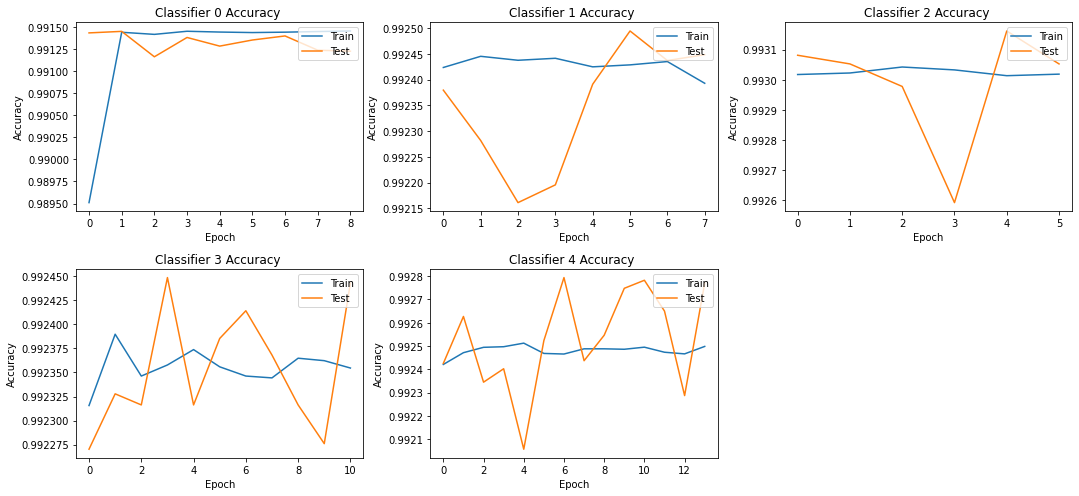

In [51]:

# Define the number of columns and rows for the grid
num_columns = 3  # You can adjust this based on your preference
num_rows = 2     # You may need to adjust this based on the number of columns

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

for idx in range(len(os.listdir(picklespath))):
    row = idx // num_columns
    col = idx % num_columns
    with open(f'%smodelhists_{idx}.pickle'%(picklespath), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        [rec_hist, clf_hist] = u.load()
        accuracy = clf_hist['accuracy']
        print(f'classifier {idx} accuracy : {accuracy}')
        
        axs[row,col].plot(clf_hist['accuracy'], label='Train')
        axs[row,col].plot(clf_hist['val_accuracy'], label='Test')
        axs[row, col].set_title(f'Classifier {idx} Accuracy ')
        axs[row, col].set_xlabel('Epoch')
        axs[row, col].set_ylabel('Accuracy')
        axs[row, col].legend(loc='upper right')

        
#         loss = clf_hist['loss']
#         print(f'classifier {idx} loss : {loss}')
#         axs[row,col].plot(clf_hist['loss'], label='Train')
#         axs[row,col].plot(clf_hist['val_loss'], label='Test')
#         axs[row,col].set_title(f'Mean Squared Error {idx}')
#         axs[row,col].set_xlabel('Epoch')
#         axs[row,col].set_ylabel('Mean Squared Error')
#         axs[row, col].legend(loc='upper right')
fig.delaxes(axs[1][2])

plt.tight_layout()
plt.savefig('./spits/plots/classificationplots.pdf')
plt.show()

In [38]:
from matplotlib import cm
jet_cm = cm.get_cmap('jet', np.unique(train_y))
colors = jet_cm(np.arange(0,1,0.5))
print(colors)

[[0.  0.  0.5 1. ]
 [0.5 0.  0.  1. ]]


In [7]:
from matplotlib import cm
RdBu_cm = cm.get_cmap('RdYlBu', 2)
colors = RdBu_cm(np.arange(0,1,0.5))
print(colors)

[[0.64705882 0.         0.14901961 1.        ]
 [0.19215686 0.21176471 0.58431373 1.        ]]


In [ ]:
feature = loadmodels.model_ecd.predict(train_x)[:,14]

m_max = np.max(feature)
m_min = np.min(feature)

bins = np.linspace(m_min, m_max, 20)

In [ ]:
train

row: 0, col: 0
row: 0, col: 1
row: 0, col: 2
row: 0, col: 3
row: 1, col: 0
row: 1, col: 1
row: 1, col: 2
row: 1, col: 3
row: 2, col: 0
row: 2, col: 1
row: 2, col: 2
row: 2, col: 3
row: 3, col: 0
row: 3, col: 1
row: 3, col: 2
row: 3, col: 3


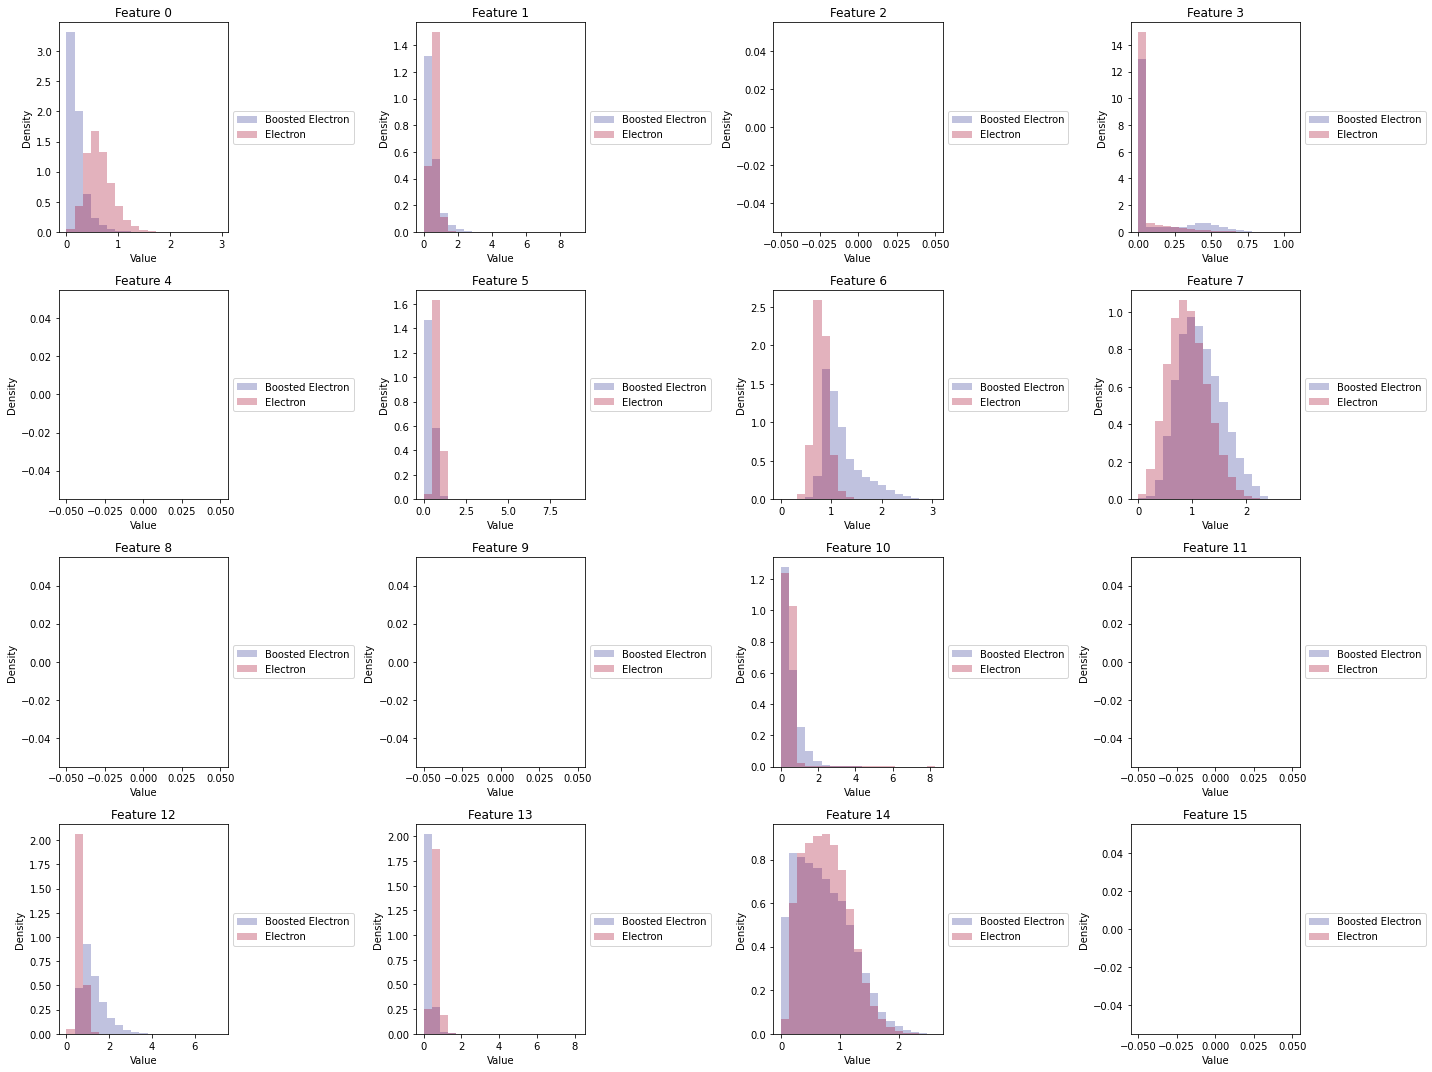

In [22]:
# Define the number of columns and rows for the grid
num_columns = 4# You can adjust this based on your preference
num_rows = 4     # You may need to adjust this based on the number of columns

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

for ifeature in range(0,16):
    feature = loadmodels.model_ecd.predict(train_x)[:,ifeature]
    row = ifeature // num_columns
    col = ifeature % num_columns
    print('row: %i, col: %i'%(row, col))
    
    m_max = np.max(feature)
    m_min = np.min(feature)
    
    bins = np.linspace(m_min, m_max, 20)
    
    # for iclass in range(2):
    #     axs[row, col].hist(feature[train_y==iclass], bins=bins, 
    #                        fc=colors[iclass], density=True, alpha=0.3,
    #                        label='Class %i'%(iclass)
    #                       )

    axs[row, col].hist(feature[train_y==1], bins=bins, 
                        fc=colors[1], density=True, alpha=0.3,
                        label='Boosted Electron'
                        )
    axs[row, col].hist(feature[train_y==0], bins=bins, 
                        fc=colors[0], density=True, alpha=0.3,
                        label='Electron'
                        )

    axs[row, col].set_title(f'Feature {ifeature}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    
# Remove any empty subplots
for i in range(16, num_columns * num_rows):
    fig.delaxes(axs.flatten()[i])

# Show the plot
plt.tight_layout()
plt.savefig('./spits/plots/histperallfeatures.png')
plt.show()

row: 0, col: 0
row: 0, col: 1
row: 0, col: 2
row: 1, col: 0
row: 1, col: 1
row: 1, col: 2


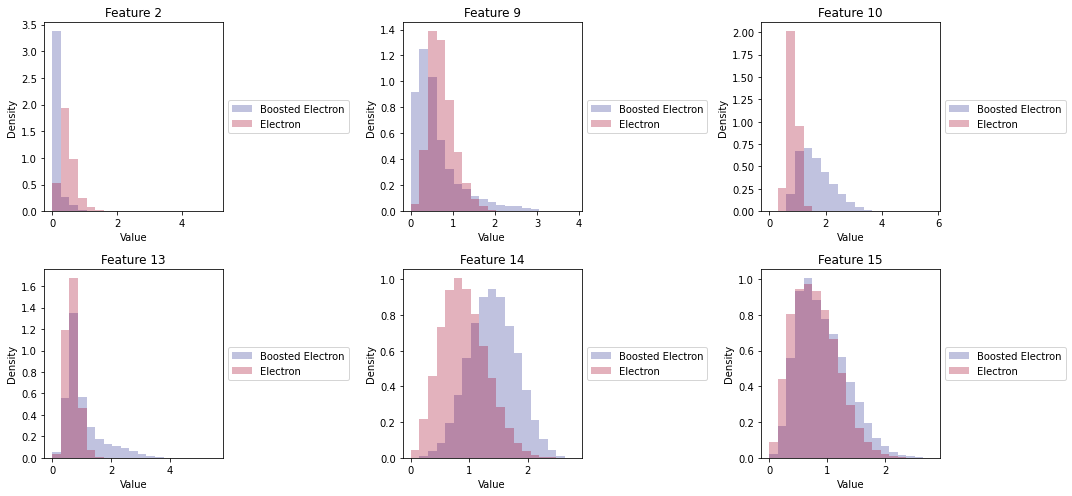

In [8]:
# Define the number of columns and rows for the grid
num_columns = 3# You can adjust this based on your preference
num_rows = 2    # You may need to adjust this based on the number of columns

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

selected_features = [2,9,10,13,14,15]

idx = 0
for ifeature in selected_features:
    
    feature = loadmodels.model_ecd.predict(train_x)[:,ifeature]
    row = idx // num_columns
    col = idx % num_columns
    print('row: %i, col: %i'%(row, col))
    idx += 1
    
    m_max = np.max(feature)
    m_min = np.min(feature)
    
    bins = np.linspace(m_min, m_max, 20)
    
    # for iclass in range(2):
    #     axs[row, col].hist(feature[train_y==iclass], bins=bins, 
    #                        fc=colors[iclass], density=True, alpha=0.3,
    #                        label='Class %i'%(iclass)
    #                       )

    axs[row, col].hist(feature[train_y==1], bins=bins, 
                        fc=colors[1], density=True, alpha=0.3,
                        label='Boosted Electron'
                        )
    axs[row, col].hist(feature[train_y==0], bins=bins, 
                        fc=colors[0], density=True, alpha=0.3,
                        label='Electron'
                        )

    axs[row, col].set_title(f'Feature {ifeature}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    


# Show the plot
plt.tight_layout()
plt.savefig('./spits/plots/histperfeature.pdf')
plt.show()

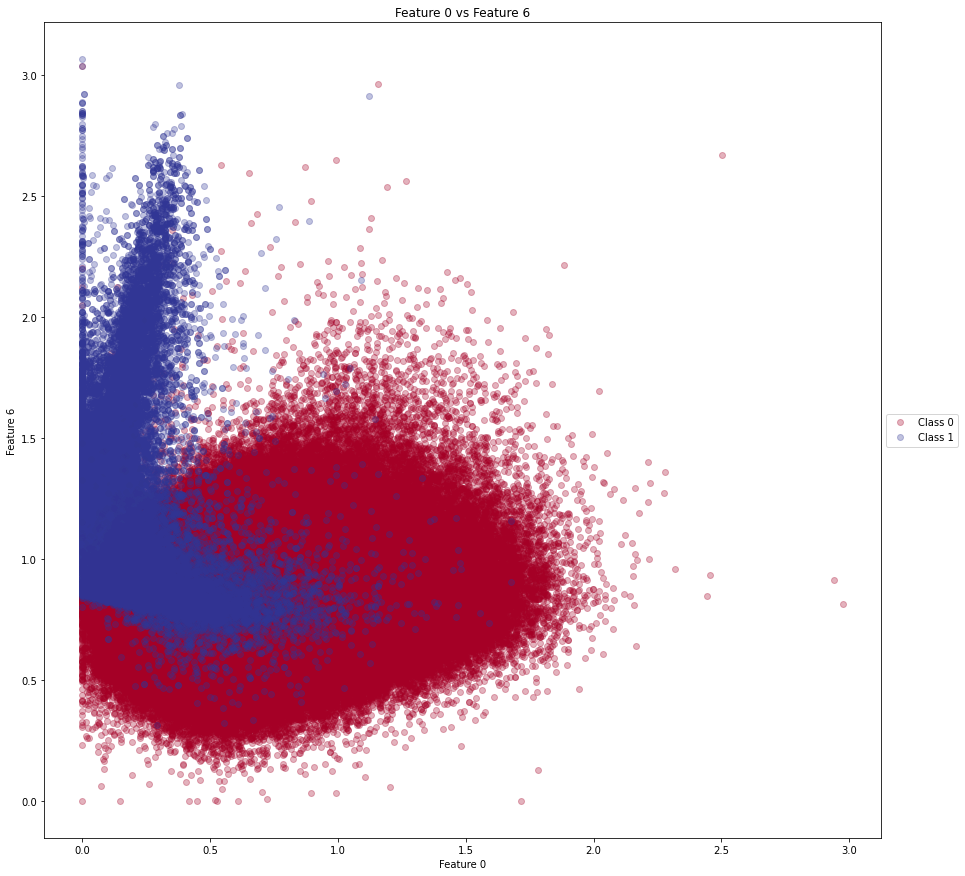

In [31]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

feature = loadmodels.model_ecd.predict(train_x)

x_feature = 0
y_feature = 6

for iclass in range(2):
    axs.plot(feature[train_y==iclass,x_feature],
             feature[train_y==iclass,y_feature],
             'o',
             color=colors[iclass], alpha=0.3,
             label='Class %i'%(iclass)
            )
axs.set_title(f'Feature {x_feature} vs Feature {y_feature}')
axs.set_xlabel(f'Feature {x_feature}')
axs.set_ylabel(f'Feature {y_feature}')
axs.legend(loc='center left',bbox_to_anchor=(1, 0.5))

In [33]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [35]:
np.unique(train_y)

array([0, 1])

In [34]:
class_weights

array([ 0.51153221, 22.17842059])

In [ ]:
output.shape

In [ ]:
# Define the number of columns and rows for the grid
num_columns = 4  # You can adjust this based on your preference
num_rows = 3     # You may need to adjust this based on the number of columns

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

output = loadmodels.predict(train_x)

for ifeature in range(0,10):
    feature = output[:,ifeature]
    row = ifeature // num_columns
    col = ifeature % num_columns
    print('row: %i, col: %i'%(row, col))
    
    m_max = np.max(feature)
    m_min = np.min(feature)
    
    bins = np.linspace(m_min, m_max, 20)
    
    for iclass in range(10):
        axs[row, col].hist(feature[train_y==iclass], bins=bins, 
                           fc=colors[iclass], density=True, alpha=0.3,
                           label='Class %i'%(iclass)
                          )

    axs[row, col].set_title(f'Feature {ifeature}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    


# Show the plot
plt.tight_layout()

### Outside fold performancemodel_output7 = loadmodels.predict(test_x_7)


In [43]:
model_output7 = loadmodels.predict(test_x_7)
predicted_class7 = np.argmax(model_output7, axis=1)
print(classification_report(test_y_7, predicted_class7))

DiscriminateAutoEncoder.predict Function
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    169954
           1       0.91      0.76      0.83      3920

    accuracy                           0.99    173874
   macro avg       0.95      0.88      0.91    173874
weighted avg       0.99      0.99      0.99    173874



In [21]:
from sklearn.metrics import classification_report

for fold in range(10):
    print('data from Fold ',fold)
    test_x = df[df[f'is_train_fold_{fold}'] == False].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()
    test_y = df[df[f'is_train_fold_{fold}'] == False]['targets'].to_numpy().astype(int)
    
    model_output = loadmodels.predict(test_x)
    predicted_class = np.argmax(model_output, axis=1)
    print(classification_report(test_y, predicted_class))

data from Fold  0
DiscriminateAutoEncoder.predict Function
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    169955
           1       0.90      0.76      0.83      3920

    accuracy                           0.99    173875
   macro avg       0.95      0.88      0.91    173875
weighted avg       0.99      0.99      0.99    173875

data from Fold  1
DiscriminateAutoEncoder.predict Function
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    169954
           1       0.91      0.76      0.83      3920

    accuracy                           0.99    173874
   macro avg       0.95      0.88      0.91    173874
weighted avg       0.99      0.99      0.99    173874

data from Fold  2
DiscriminateAutoEncoder.predict Function
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    169954
           1       0.91      0.76      0.83      3920

    a

In [46]:
std_accuracy

7.407194408133561e-05

data from Fold  0
DiscriminateAutoEncoder.predict Function
accuracy: 0.9927706685837527
data from Fold  1
DiscriminateAutoEncoder.predict Function
accuracy: 0.9928799015378953
data from Fold  2
DiscriminateAutoEncoder.predict Function
accuracy: 0.9928568963732358
data from Fold  3
DiscriminateAutoEncoder.predict Function
accuracy: 0.9927246166764438
data from Fold  4
DiscriminateAutoEncoder.predict Function
accuracy: 0.9927591244234331
data from Fold  5
DiscriminateAutoEncoder.predict Function
accuracy: 0.992718865385279
data from Fold  6
DiscriminateAutoEncoder.predict Function
accuracy: 0.9926268447266411
data from Fold  7
DiscriminateAutoEncoder.predict Function
accuracy: 0.9927936321704223
data from Fold  8
DiscriminateAutoEncoder.predict Function
accuracy: 0.9928108860439169
data from Fold  9
DiscriminateAutoEncoder.predict Function
accuracy: 0.9926785642394161


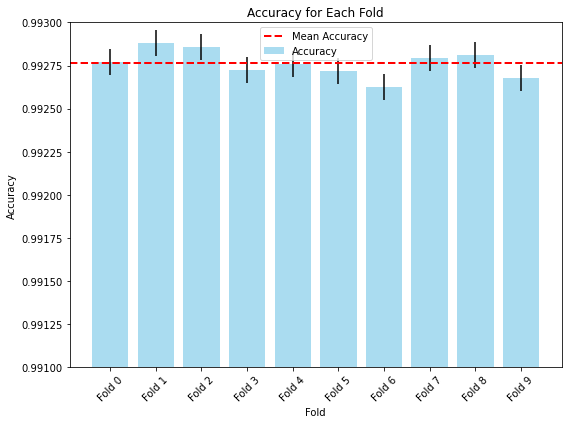

In [39]:
from sklearn.metrics import accuracy_score

accuracies = []
for fold in range(10):
    print('data from Fold ',fold)
    test_x = df[df[f'is_train_fold_{fold}'] == False].drop(['targets','is_train_fold_0','is_train_fold_1','is_train_fold_2','is_train_fold_3','is_train_fold_4','is_train_fold_5','is_train_fold_6','is_train_fold_7','is_train_fold_8','is_train_fold_9'], axis=1).to_numpy()
    test_y = df[df[f'is_train_fold_{fold}'] == False]['targets'].to_numpy().astype(int)
    
    model_output = loadmodels.predict(test_x)
    predicted_class = np.argmax(model_output, axis=1)
    accuracy = accuracy_score(test_y, predicted_class)
    print('accuracy:', accuracy)
    accuracies.append(accuracy)
    
# Calculate mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Create a bar plot to visualize the mean and standard deviation of accuracies
plt.figure(figsize=(8, 6))
plt.bar(['Fold 0', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9'],
        accuracies, yerr= std_accuracy, color='skyblue', alpha=0.7, label='Accuracy')
plt.axhline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Fold')
plt.legend()
plt.ylim(0.991, 0.993)  # Set the y-axis limit for accuracy between 0 and 1
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()